# PC Lab 2

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm

## Task 1

As a first step of our analysis, we will download, inspect and process our data.

In [2]:
# import the data into a dataframe and inspect it
data_raw = pd.read_csv('Data_PCLab1_stock.csv', parse_dates=['Date']) #the last argument ensures that the 'Date' column is parsed as a datetime object
display(data_raw.head())

print(f'The file contains {data_raw.shape[0]} observations for {data_raw.shape[1] - 1} securities.')
print(f'They span from {data_raw.Date.min().strftime("%Y-%m-%d")} to {data_raw.Date.max().strftime("%Y-%m-%d")}.')

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


The file contains 2159 observations for 9 securities.
They span from 2012-01-12 to 2020-08-11.


In [3]:
# inspect the data types of the columns
data_raw.dtypes

Date     datetime64[ns]
AAPL            float64
BA              float64
T               float64
MGM             float64
AMZN            float64
IBM             float64
TSLA            float64
GOOG            float64
sp500           float64
dtype: object

In [4]:
# inspect the data for missing values
data_raw.isnull().sum()

Date     0
AAPL     0
BA       0
T        0
MGM      0
AMZN     0
IBM      0
TSLA     0
GOOG     0
sp500    0
dtype: int64

Since the data has been imported in the right format, and there are no missing, we can proceed with an initial analysis of the returns. In particular, we will inspect the daily returns of the stocks and compare them to the market's (S&P500 index) performance. This should give us an initial idea on the level of correlation between each security and the market.

In [5]:
#we define a function that computes the daily returns of the stocks through the percentage change in price
def stocks_returns(data, stocks_tickers):
    data_returns = data.copy() # create a copy of the original dataset to avoid modifying it
    data_returns[stocks_tickers] = data_returns[stocks_tickers].apply(lambda x: x.pct_change()) #we apply the pct_change() method to each column
    return data_returns

In [6]:
#we define a list of names and tickers for the stocks which will be useful for our analysis
stocks_tickers = list(data_raw.columns[1:]) #we exclude the 'Date' column
stocks_names = ['Apple', 'Boeing', 'AT&T', 'MGM', 'Amazon', 'IBM', 'Tesla', 'Google', 'S&P500']

In [7]:
data_returns = stocks_returns(data_raw, stocks_tickers) #apply the function to our dataset
data_returns = data_returns[1:] #remove the first row of the dataset as it contains NaN values
data_returns.head() #inspect the newly generated dataset

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
1,2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948
2,2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553
3,2012-01-18,0.010384,-0.002392,0.002645,0.039184,0.042827,0.005944,0.007895,0.006889,0.011108
4,2012-01-19,-0.003169,0.006661,0.002967,0.005499,0.026446,-0.003038,-0.001865,0.010523,0.004939
5,2012-01-20,-0.017417,-0.000529,0.002959,-0.012500,-0.018102,0.044316,-0.005979,-0.083775,0.000669


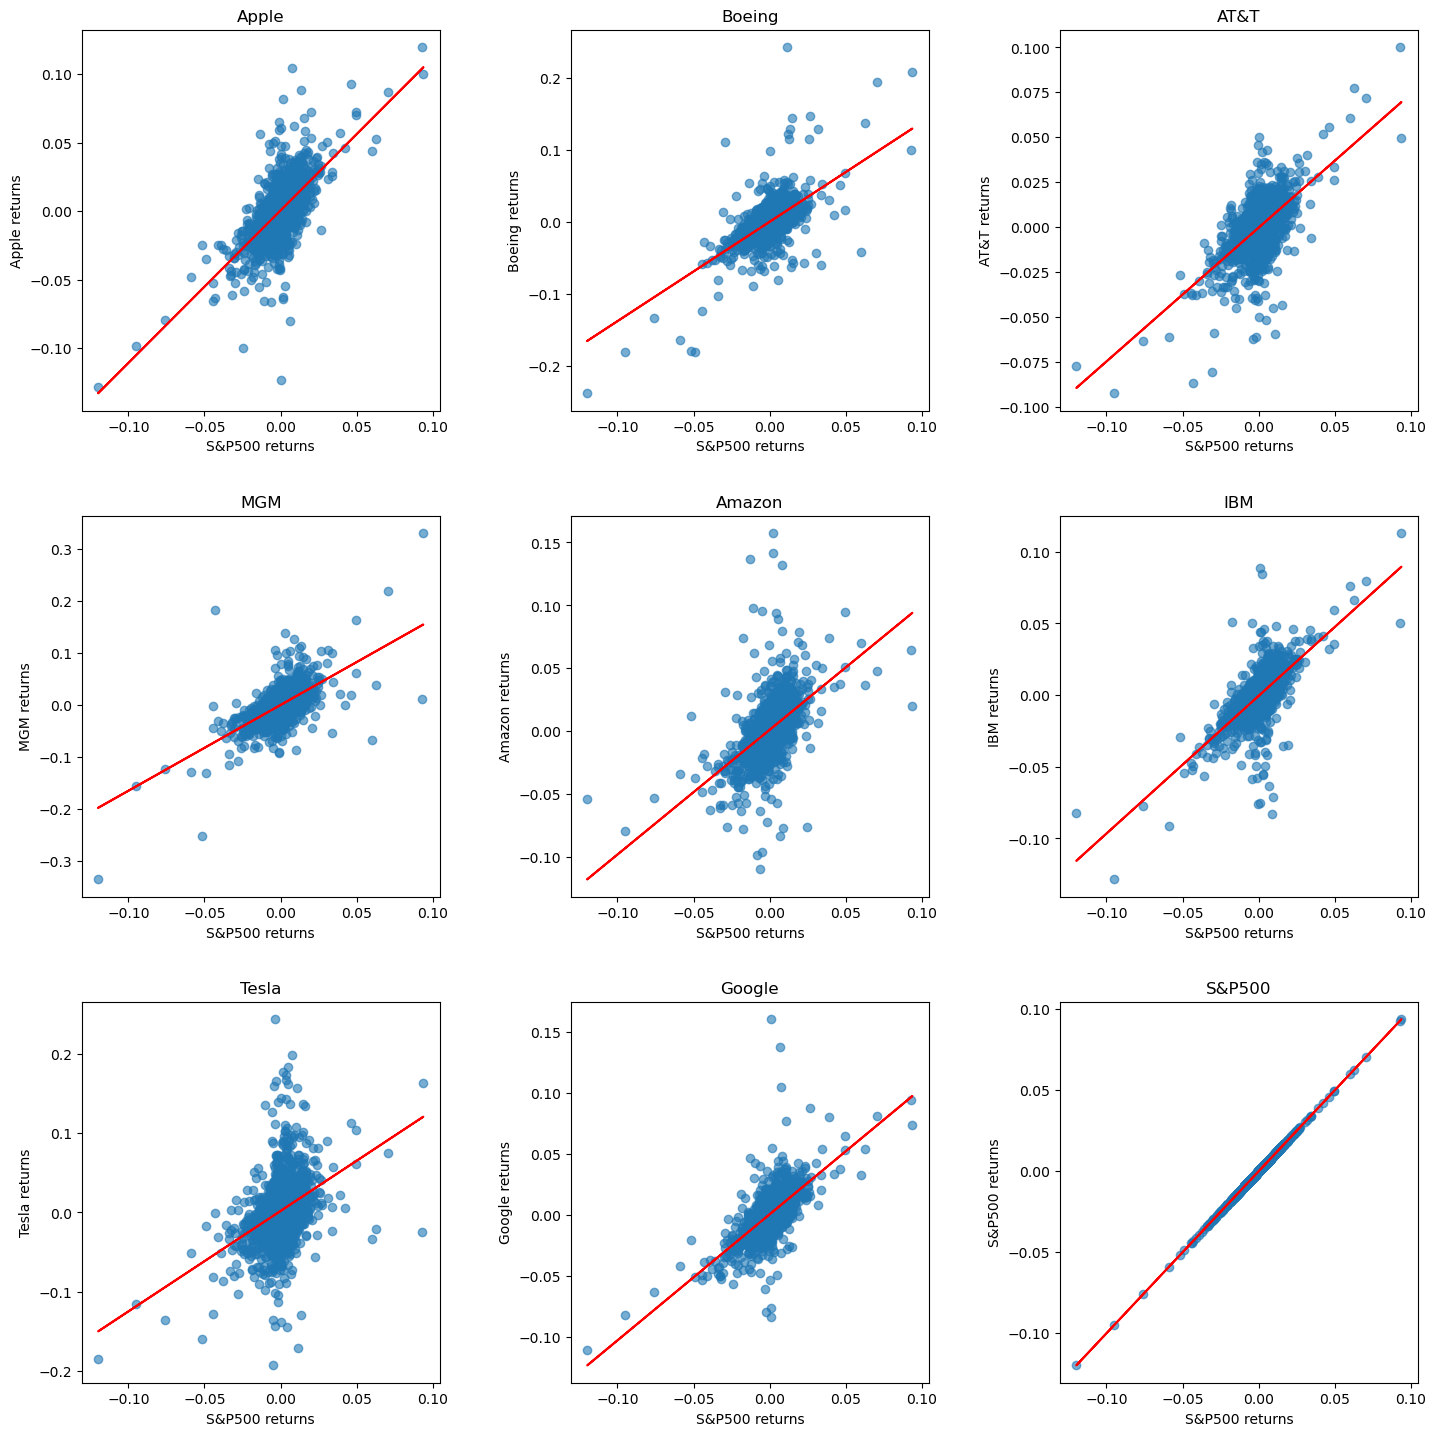

In [8]:
#for each stock, we make a scatter plot that compares its reutrns to the returns of the S&P500 index
fig, axs = plt.subplots(3,3, figsize=(15, 15)) #create a 3x3 grid of subplots
axs = axs.flatten() #flatten the grid to iterate over it more easily
for i, stock in enumerate(stocks_tickers): 
    axs[i].scatter(data_returns['sp500'], data_returns[stock], alpha=0.6) #scatter plot of the stock's returns vs. the S&P500 returns
    axs[i].plot(data_returns['sp500'], np.poly1d(np.polyfit(data_returns['sp500'], data_returns[stock], 1))(data_returns['sp500']), color='red') #add a linear regression line
    axs[i].set_title(stocks_names[i]) 
    axs[i].set_xlabel('S&P500 returns') 
    axs[i].set_ylabel(f'{stocks_names[i]} returns')
plt.tight_layout(pad=3.0)
plt.show()

As it can be observed from the previous plots, the level of correlation between each stock and the market varies significantly. Furthermore, the plotted regression line provides a better understanding of such relationships. In particular, it appears that Tesla's stock has the lowest correlation with the market. In a similar fashion, Amazon scatterplot exhibits a weak level of correlation between its returns and those of the market. On the other hand, IBM, Google and MGM seem to have stronger correlations.
To confirm these initial observations, we will compute the correlations between each stock and the market, and see if the numerical data match our visual results

In [9]:
#we further analyze the relationship between the returns of the stocks and the S&P500 index by computing the correlation between them
correlation = data_returns.iloc[:,1:].corr() #compute the correlation matrix
correlation = correlation.loc['sp500', stocks_tickers] #extract the correlation of the S&P500 with the stocks
correlation = correlation.reset_index() #reset the index to make the dataframe more readable
correlation.columns = ['Stock', 'Correlation'] #rename the columns
correlation = correlation.sort_values(by='Correlation', ascending=False) #sort the dataframe by correlation
correlation

,Stock,Correlation
8,sp500,1.000000
5,IBM,0.703935
7,GOOG,0.684571
0,AAPL,0.657320
1,BA,0.641826
3,MGM,0.631449
2,T,0.617463
4,AMZN,0.539560
6,TSLA,0.387920


As it can be observed from the table, Tesla and Amazon show the lowest level of correlation with the market. The other securities provide similar levels of correlation, which oscillate between $0.62$ (AT&T) and $0.70$ (IBM).

### Additional (Plotly)

In [10]:
# Create a 3x3 grid of subplots using Plotly
fig = make_subplots(rows=3, cols=3, subplot_titles=stocks_names)

# Iterate over each stock and create a scatter plot with a regression line
for i, stock in enumerate(stocks_tickers):
    row = i // 3 + 1
    col = i % 3 + 1
    
    # Scatter plot of the stock's returns vs. the S&P500 returns
    fig.add_trace(
        go.Scatter(
            x=data_returns['sp500'],
            y=data_returns[stock],
            mode='markers',
            name=stocks_names[i],
            marker=dict(symbol='circle')
        ),
        row=row, col=col
    )
    
    # Add a linear regression line
    slope, intercept = np.polyfit(data_returns['sp500'], data_returns[stock], 1)
    fig.add_trace(
        go.Scatter(
            x=data_returns['sp500'],
            y=slope * data_returns['sp500'] + intercept,
            mode='lines',
            name=f'{stocks_names[i]} Regression Line',
            line=dict(color='red')
        ),
        row=row, col=col
    )

# Update layout to remove legend
fig.update_layout(height=900, width=1200, title_text="Stock Returns vs. S&P500 Returns with Regression Lines", showlegend=False)
fig.update_xaxes(title_text="S&P500 returns")
fig.update_yaxes(title_text="Stock returns")

# Show the plot
fig.show()

## Task 2

### 2.1 - Applying the CAPM using `statsmodels.api`

In [11]:
def capm(data, stock, risk_free_rate=0): # we define a function to fit the CAPM model
    data_capm = data.copy()
    X = data_capm['sp500'] - risk_free_rate # Market excess return
    X = sm.add_constant(X)  # Adds the intercept (alpha)
    y = data_capm[stock] - risk_free_rate # Stock excess return
    model = sm.OLS(y, X).fit() # Fit the model
    prediction = model.predict(X) # Get the predictions
    alpha, beta = model.params # Get the alpha and beta coefficients
    pvalue_alpha, pvalue_beta = model.pvalues # get p-values for alphas and betas
    results = model.summary()
    return prediction, alpha, beta, pvalue_beta, pvalue_alpha, results

# apply the CAPM model to each stock
for stock in stocks_tickers[:-1]:
    results = capm(data_returns, stock)[5]
    print(f'Regression summary for {stock}: \n{results}')
capm_predictions, capm_alphas, capm_betas, beta_pvalues, alpha_pvalues = [capm(data_returns, stock)[0] for stock in stocks_tickers[:-1]], [capm(data_returns, stock)[1] for stock in stocks_tickers[:-1]], [capm(data_returns, stock)[2] for stock in stocks_tickers[:-1]], [capm(data_returns, stock)[3] for stock in stocks_tickers[:-1]], [capm(data_returns, stock)[4] for stock in stocks_tickers[:-1]]

#save the results in a dataframe to be used later
capm_coeff_df = pd.DataFrame({'Stock': stocks_names[:-1], 'Stock Tickers' : stocks_tickers[:-1], 'Betas': capm_betas, 'Alphas': capm_alphas, 'P-value Beta': beta_pvalues, 'P-value Alpha': alpha_pvalues}) # we create a dataframe with the results

Regression summary for AAPL: 
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     1640.
Date:                Fri, 04 Oct 2024   Prob (F-statistic):          3.52e-267
Time:                        14:06:44   Log-Likelihood:                 6247.1
No. Observations:                2158   AIC:                        -1.249e+04
Df Residuals:                    2156   BIC:                        -1.248e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005 

In [12]:
# save predictions from the CAPM model in a dataframe
dates = pd.DataFrame(data_returns['Date'], columns=['Date']) # we create a dataframe with the dates
capm_pred_df = pd.DataFrame(capm_predictions).T # we create a dataframe with the predictions
capm_pred_df.columns = stocks_tickers[:-1] # we set the columns names
capm_pred_df.index = data_returns.index # we set the index
capm_pred_df = pd.concat([dates, capm_pred_df], axis=1) # we concatenate the dates
capm_pred_df

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
1,2012-01-13,-0.004978,-0.006865,-0.003970,-0.008351,-0.003884,-0.005287,-0.004518,-0.004787
2,2012-01-17,0.004482,0.004890,0.002360,0.005706,0.004546,0.002878,0.006266,0.004011
3,2012-01-18,0.012890,0.015338,0.007986,0.018199,0.012039,0.010133,0.015851,0.011829
4,2012-01-19,0.006025,0.006807,0.003392,0.007997,0.005920,0.004208,0.008024,0.005445
5,2012-01-20,0.001273,0.000903,0.000213,0.000938,0.001687,0.000108,0.002608,0.001027
...,...,...,...,...,...,...,...,...,...
2154,2020-08-05,0.007684,0.008869,0.004502,0.010463,0.007399,0.005640,0.009916,0.006988
2155,2020-08-06,0.007682,0.008866,0.004500,0.010460,0.007397,0.005638,0.009913,0.006986
2156,2020-08-07,0.001233,0.000852,0.000186,0.000878,0.001650,0.000073,0.002562,0.000989
2157,2020-08-10,0.003580,0.003769,0.001756,0.004366,0.003742,0.002099,0.005238,0.003172


### 2.2 - Plotting Alphas and Betas

In [13]:
# plot the betas and alphas for each stock
fig = make_subplots(rows=1, cols=2, subplot_titles=['Betas', 'Alphas']) # create a 1x2 grid of subplots

# plot the betas
fig.add_trace(
    go.Bar(x=capm_coeff_df['Stock'], y=capm_coeff_df['Betas'], marker=dict(color='blue'), name='Beta'),
    row=1, col=1
)

# plot the alphas
fig.add_trace(
    go.Bar(x=capm_coeff_df['Stock'], y=capm_coeff_df['Alphas'], marker=dict(color='red'), name='Alpha'),
    row=1, col=2
)

# update layout
fig.update_layout(height=400, width=1200, title_text="CAPM Model Coefficients", showlegend=False)
fig.update_yaxes(title_text="Value")
fig.show()

In [14]:
#display the dataframe with coefficients and their p-values
capm_coeff_df

,Stock,Stock Tickers,Betas,Alphas,P-value Beta,P-value Alpha
0,Apple,AAPL,1.112891,0.000528,3.521164e-267,0.067202
1,Boeing,BA,1.382867,-0.000023,7.299279e-251,0.951096
2,AT&T,T,0.744630,-0.000286,4.892378e-227,0.182942
3,MGM,MGM,1.653568,-0.000169,1.874186e-240,0.712986
4,Amazon,AMZN,0.991732,0.001023,2.611172e-163,0.003512
5,IBM,IBM,0.960416,-0.000535,1.185758e-322,0.014747
6,Tesla,TSLA,1.268611,0.001759,1.965135e-78,0.009920
7,Google,GOOG,1.034881,0.000334,2.345742e-298,0.180655


The plotted results and their values provide us useful insights on the model. According to the CAPM, all alphas for the analyzed securities should be zero. Therefore, their non-significance in the OLS regression is consistent with the theory.
However, the results from the previous table show that the alphas for Amazon, IBM and Tesla stocks are all different from zero and statistically significant. Furthermore, the plots reveal that these specific alphas are also the ones with the highest absolute values. 

The CAPM's failure to hold for these assets may indicate there is an excess in returns, even if we account for the systematic risk. These conclusions thus pose a severe threat to the theory behind the CAPM as it can be deduced that returns for these stocks are influenced by factors unrelated from the market.

### 2.3 Plot the errors $\epsilon_i$

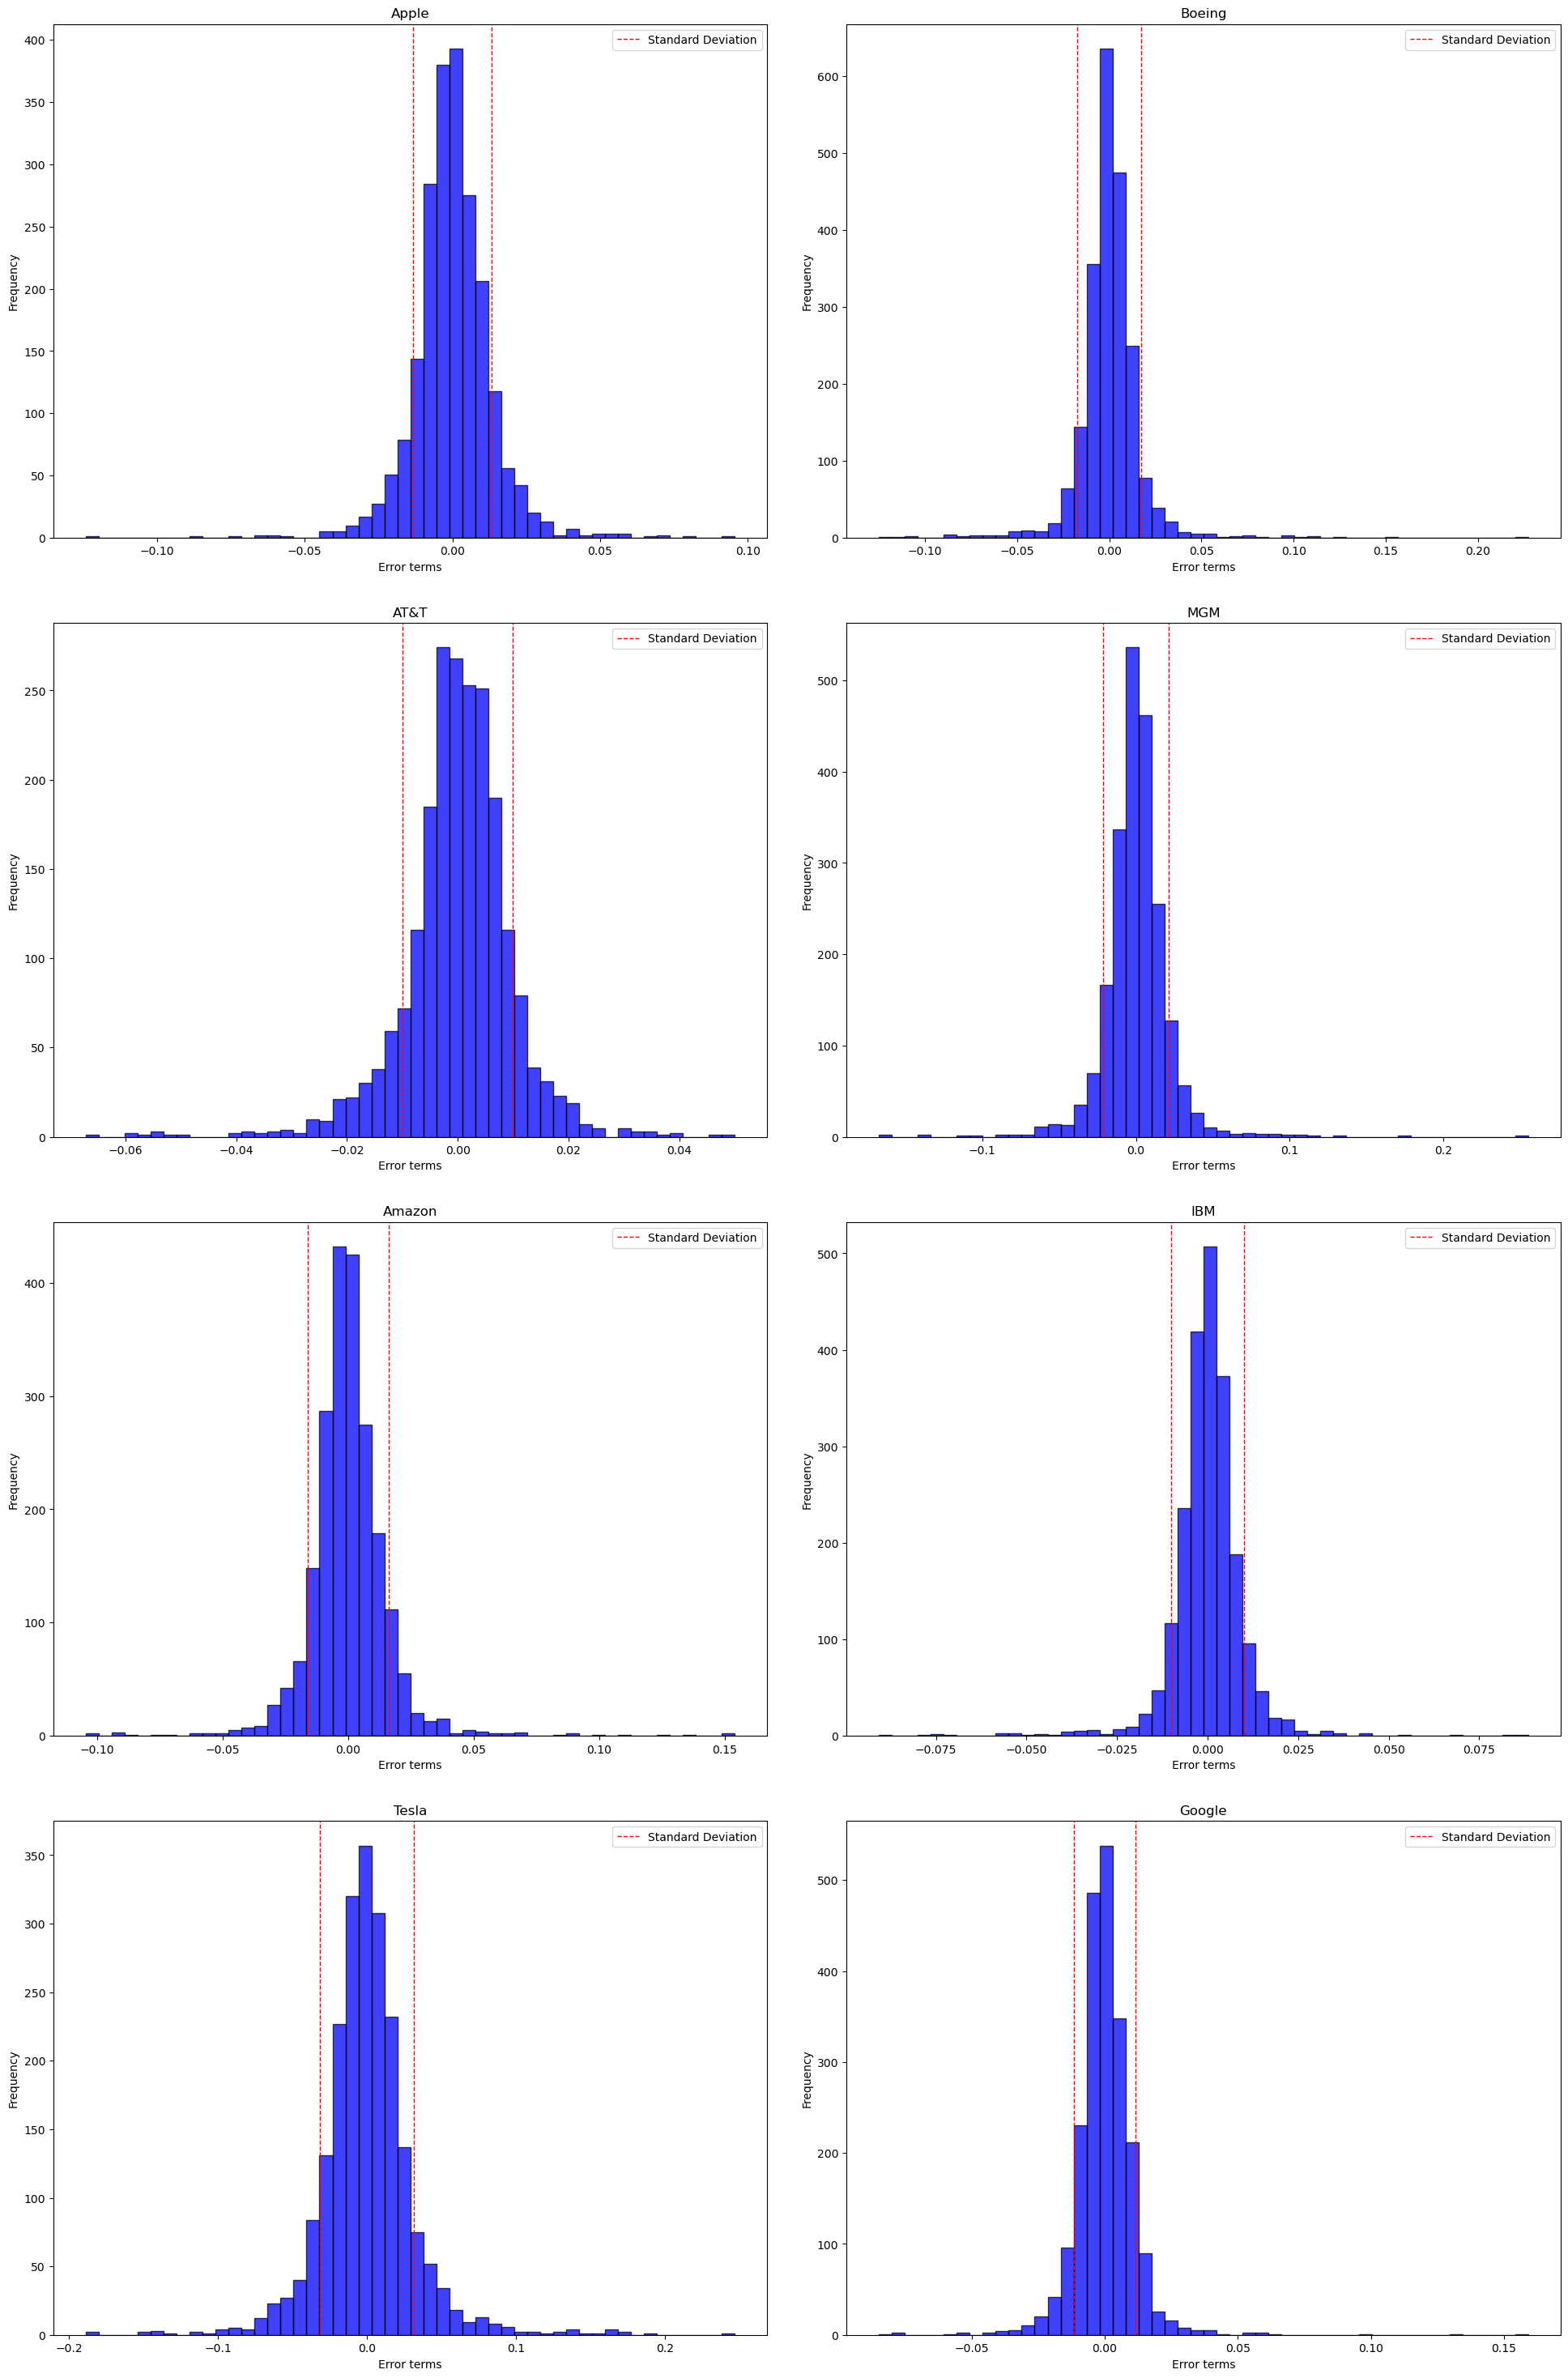

In [15]:
# Compute the error terms (epsilon_i) for each stock
errors = {stock: data_returns[stock] - capm_pred_df[stock] for stock in stocks_tickers[:-1]}

# Plot the histogram of error terms for each stock
fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # create a 4x2 grid of subplots
axs = axs.flatten()  # flatten the grid to iterate over it more easily

for i, stock in enumerate(stocks_tickers[:-1]):
    axs[i].hist(errors[stock], bins=50, alpha=0.75, color='blue', edgecolor='black')
    axs[i].set_title(stocks_names[i])
    # add lines for the standard deviation of the errors on both sides of the mean
    axs[i].axvline(np.std(errors[stock]), color='red', linestyle='dashed', linewidth=1, label='Standard Deviation')
    axs[i].axvline(-np.std(errors[stock]), color='red', linestyle='dashed', linewidth=1)
    # set the labels
    axs[i].set_xlabel('Error terms')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

plt.tight_layout(pad=3.0)
plt.show()

By plotting histograms of the error terms, it can be observed the level of non-systematic risk associated to each stock. As an example, Tesla and AT&T stocks' error terms exhibit higher standard deviations than those of the error terms for other stocks. It can thus be suggested that these two securities are subject to higher idiosyncratic risk

### 2.4 - Portfolio of high-beta stocks
Your boss wants to take a lot of risk to deliver high return. He asks you to (i) select the 4 riskier assets (over the full period), (ii) form an equally weighted portfolio, and (iii) to estimate the portfolio return based on parameters (β and rm) estimated above.

In [16]:
capm_coeff_df_sorted = capm_coeff_df.sort_values(by='Betas', ascending=False).reset_index(drop=True) # we sort the dataframe by the beta coefficient
capm_coeff_df_sorted

,Stock,Stock Tickers,Betas,Alphas,P-value Beta,P-value Alpha
0,MGM,MGM,1.653568,-0.000169,1.874186e-240,0.712986
1,Boeing,BA,1.382867,-0.000023,7.299279e-251,0.951096
2,Tesla,TSLA,1.268611,0.001759,1.965135e-78,0.009920
3,Apple,AAPL,1.112891,0.000528,3.521164e-267,0.067202
4,Google,GOOG,1.034881,0.000334,2.345742e-298,0.180655
5,Amazon,AMZN,0.991732,0.001023,2.611172e-163,0.003512
6,IBM,IBM,0.960416,-0.000535,1.185758e-322,0.014747
7,AT&T,T,0.744630,-0.000286,4.892378e-227,0.182942


In [17]:
#we save the stocks with the highest beta coefficients
higher_beta_stocks = [x for x in capm_coeff_df_sorted.iloc[:4,0]]
higher_beta_stocks

['MGM', 'Boeing', 'Tesla', 'Apple']

In [18]:
#prepare data for equal weighted portfolio
ew_portfolio = pd.DataFrame(data_returns['Date'], columns=['Date'])

#we create a dataframe with the equal weighted portfolio
h_stocks = ['MGM', 'BA', 'TSLA', 'AAPL'] #tickers for higher beta stocks
ew_portfolio = pd.concat([ew_portfolio, data_returns[h_stocks]], axis=1)
ew_portfolio

,Date,MGM,BA,TSLA,AAPL
1,2012-01-13,0.018137,-0.012051,-0.193274,-0.003749
2,2012-01-17,-0.008097,0.008579,0.167179,0.011648
3,2012-01-18,0.039184,-0.002392,0.007895,0.010384
4,2012-01-19,0.005499,0.006661,-0.001865,-0.003169
5,2012-01-20,-0.012500,-0.000529,-0.005979,-0.017417
...,...,...,...,...,...
2154,2020-08-05,0.000000,0.055794,-0.001332,0.003625
2155,2020-08-06,0.104067,-0.011935,0.003071,0.034889
2156,2020-08-07,0.030878,-0.012660,-0.024752,-0.024495
2157,2020-08-10,0.137677,0.055229,-0.023501,0.014535


In [19]:
#we compute the return of the equal weighted portfolio by taking the average of the returns of the stocks
ew_portfolio['Portfolio Avg. Return'] = ew_portfolio.iloc[:,1:].mean(axis=1) 
ew_portfolio

,Date,MGM,BA,TSLA,AAPL,Portfolio Avg. Return
1,2012-01-13,0.018137,-0.012051,-0.193274,-0.003749,-0.047735
2,2012-01-17,-0.008097,0.008579,0.167179,0.011648,0.044827
3,2012-01-18,0.039184,-0.002392,0.007895,0.010384,0.013767
4,2012-01-19,0.005499,0.006661,-0.001865,-0.003169,0.001781
5,2012-01-20,-0.012500,-0.000529,-0.005979,-0.017417,-0.009106
...,...,...,...,...,...,...
2154,2020-08-05,0.000000,0.055794,-0.001332,0.003625,0.014522
2155,2020-08-06,0.104067,-0.011935,0.003071,0.034889,0.032523
2156,2020-08-07,0.030878,-0.012660,-0.024752,-0.024495,-0.007757
2157,2020-08-10,0.137677,0.055229,-0.023501,0.014535,0.045985


In [20]:
def predictions(data, stock, coeff, risk_free_rate=0): # prediction of the excess return of the equally weighted portfolio using betas and market returns from above
    data = data.copy()
    excess_return = risk_free_rate + coeff.loc[coeff['Stock Tickers'] == stock, 'Betas'].values[0] * (data['sp500'] - risk_free_rate) + coeff.loc[coeff['Stock Tickers'] == stock, 'Alphas'].values[0]
    return excess_return

ew_pred = [predictions(data_returns, stock, capm_coeff_df) for stock in h_stocks] #call the function for each stock

ew_pred_df = pd.DataFrame(ew_pred).T # we create a dataframe with the predictions
ew_pred_df.columns = h_stocks # we set the columns names
ew_pred_df.index = data_returns.index # we set the index
ew_pred_df = pd.concat([dates, ew_pred_df], axis=1) # we concatenate the dates
ew_pred_df['Portfolio Avg. Return'] = ew_pred_df.iloc[:,1:].mean(axis=1) #create a column with the portfolio return by averaging the returns of the stocks
ew_pred_df

,Date,MGM,BA,TSLA,AAPL,Portfolio Avg. Return
1,2012-01-13,-0.008351,-0.006865,-0.004518,-0.004978,-0.006178
2,2012-01-17,0.005706,0.004890,0.006266,0.004482,0.005336
3,2012-01-18,0.018199,0.015338,0.015851,0.012890,0.015569
4,2012-01-19,0.007997,0.006807,0.008024,0.006025,0.007213
5,2012-01-20,0.000938,0.000903,0.002608,0.001273,0.001431
...,...,...,...,...,...,...
2154,2020-08-05,0.010463,0.008869,0.009916,0.007684,0.009233
2155,2020-08-06,0.010460,0.008866,0.009913,0.007682,0.009230
2156,2020-08-07,0.000878,0.000852,0.002562,0.001233,0.001381
2157,2020-08-10,0.004366,0.003769,0.005238,0.003580,0.004238


In [21]:
#compute annual predicted returns of the equal weighted portfolio
ew_pred_df['Portfolio Avg. Return'].mean() * 252

0.30043639321452137

In [22]:
#compute annual observed returns of the equal weighted portfolio
ew_portfolio['Portfolio Avg. Return'].mean() * 252

0.30043639321452137

In [23]:
#plot actual and predicted returns of the equal weighted portfolio
fig = go.Figure()
fig.add_trace(go.Scatter(x=ew_portfolio['Date'], y=ew_portfolio['Portfolio Avg. Return'].cumsum(), mode='lines', name='Actual Portfolio Returns'))
fig.add_trace(go.Scatter(x=ew_pred_df['Date'], y=ew_pred_df['Portfolio Avg. Return'].cumsum(), mode='lines', name='Predicted Portfolio Returns'))
fig.update_layout(title='Actual vs. Predicted Returns of the Equal Weighted Portfolio', xaxis_title='Date', yaxis_title='Cumulative Returns')
fig.show()


From the previous results it can be observed that the returns we can obtain by using the betas and the alphas of the stocks are generally an acceptable approximation of the actual returns. This is due to the fact that the betas we used were computed by using the returns of those stocks for the whole period. Therefore, for the last part of our analysis, we will try to see if they are useful for predicting future results

## Task 3

In [24]:
#we create a dataframe with the returns labeled by year
returns_labeled = data_returns.copy()
dates['Year'] = dates['Date'].dt.year #extract the year from the date column
returns_labeled = pd.concat([dates['Year'], returns_labeled], axis=1) #concatenate the year column to the returns dataframe
returns_labeled

,Year,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
1,2012,2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948
2,2012,2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553
3,2012,2012-01-18,0.010384,-0.002392,0.002645,0.039184,0.042827,0.005944,0.007895,0.006889,0.011108
4,2012,2012-01-19,-0.003169,0.006661,0.002967,0.005499,0.026446,-0.003038,-0.001865,0.010523,0.004939
5,2012,2012-01-20,-0.017417,-0.000529,0.002959,-0.012500,-0.018102,0.044316,-0.005979,-0.083775,0.000669
...,...,...,...,...,...,...,...,...,...,...,...
2154,2020,2020-08-05,0.003625,0.055794,-0.005332,0.000000,0.021091,-0.003099,-0.001332,0.005898,0.006430
2155,2020,2020-08-06,0.034889,-0.011935,-0.000335,0.104067,0.006231,0.005341,0.003071,0.017976,0.006428
2156,2020,2020-08-07,-0.024495,-0.012660,0.006032,0.030878,-0.017842,-0.009198,-0.024752,-0.003740,0.000633
2157,2020,2020-08-10,0.014535,0.055229,0.005996,0.137677,-0.006093,0.017206,-0.023501,0.001077,0.002742


In [25]:
#we make a loop for each unique year in the dataset and use the capm function to compute the beta coefficients for each stock for that year
yearly_betas = [{stock : capm(returns_labeled.loc[returns_labeled['Year'] == year], stock)[2] 
                 for stock in stocks_tickers[:-1]} for year in returns_labeled['Year'].unique()] 
                #the output of is a list of dictionaries, where each dictionary contains the beta coefficients for each stock for a specific year

#we print the results
for i, year in enumerate(returns_labeled['Year'].unique()):
    print(f'Betas for year {year}: {yearly_betas[i]}')



Betas for year 2012: {'AAPL': 1.283027738940946, 'BA': 1.0246158580752187, 'T': 0.6162648735132784, 'MGM': 1.732747308066556, 'AMZN': 1.1230736259046856, 'IBM': 0.8566190880679743, 'TSLA': 1.6114165152852131, 'GOOG': 0.8603343617128557}
Betas for year 2013: {'AAPL': 0.6265656188230019, 'BA': 0.9666729081540442, 'T': 0.7845433985651341, 'MGM': 1.5262879960112024, 'AMZN': 1.26546638585816, 'IBM': 0.7654909542429029, 'TSLA': 1.1745051257892145, 'GOOG': 0.9451686770414216}
Betas for year 2014: {'AAPL': 0.8354904247202517, 'BA': 1.0210587764507713, 'T': 0.564327269989813, 'MGM': 1.4923316317571724, 'AMZN': 1.4633601571110213, 'IBM': 0.7293458759394109, 'TSLA': 1.900734787789434, 'GOOG': 1.2798239705160204}
Betas for year 2015: {'AAPL': 1.14507492837777, 'BA': 0.999671841739458, 'T': 0.7211187784753244, 'MGM': 1.479366486512812, 'AMZN': 1.119325555917146, 'IBM': 1.0193570871426658, 'TSLA': 1.1366433330795664, 'GOOG': 1.0846025653386087}
Betas for year 2016: {'AAPL': 1.0099620647427996, 'BA':

In [26]:
#we create a dataframe with the beta coefficients for each stock for each year
predictions_betas_df = pd.DataFrame(yearly_betas, index=returns_labeled['Year'].unique())
predictions_betas_df.columns = [col + ' Beta' for col in predictions_betas_df.columns]
predictions_betas_df['Year'] = predictions_betas_df.index
predictions_betas_df.reset_index(drop=True, inplace=True)
predictions_betas_df



,AAPL Beta,BA Beta,T Beta,MGM Beta,AMZN Beta,IBM Beta,TSLA Beta,GOOG Beta,Year
0,1.283028,1.024616,0.616265,1.732747,1.123074,0.856619,1.611417,0.860334,2012
1,0.626566,0.966673,0.784543,1.526288,1.265466,0.765491,1.174505,0.945169,2013
2,0.835490,1.021059,0.564327,1.492332,1.463360,0.729346,1.900735,1.279824,2014
3,1.145075,0.999672,0.721119,1.479366,1.119326,1.019357,1.136643,1.084603,2015
4,1.009962,1.217194,0.476372,1.669338,1.116334,0.931592,1.215942,0.952996,2016
5,1.376087,0.997476,0.762074,1.439209,1.311298,0.664218,1.357621,1.263186,2017
6,1.255214,1.311227,0.659487,1.355182,1.623267,0.967147,1.378808,1.371131,2018
7,1.558167,0.981311,0.577960,1.336059,1.327099,1.075293,1.317051,1.290719,2019
8,1.070752,1.735518,0.875194,1.847119,0.605983,1.011492,1.143629,0.906244,2020


In [27]:
returns_labeled['Year of Beta to use'] = returns_labeled['Year'] - 1 #we shift the years by one to use the beta coefficients of the previous year
final_df = pd.merge(returns_labeled, predictions_betas_df, left_on='Year of Beta to use', right_on='Year', how='left') #we merge the two dataframes


In [28]:
final_df = final_df.groupby('Year_x').agg({'AAPL':'mean', 'BA':'mean', 'T':'mean', 'MGM':'mean', 'AMZN':'mean', 'IBM':'mean', 'TSLA':'mean', 'GOOG':'mean', 'sp500':'mean',
                                'AAPL Beta':'mean', 'BA Beta':'mean', 'T Beta':'mean', 'MGM Beta':'mean', 'AMZN Beta':'mean', 'IBM Beta':'mean', 'TSLA Beta':'mean', 'GOOG Beta':'mean'
                                }) #we group the data by year and compute the average returns for each stock


final_df.loc[:,'AAPL':'sp500'] = final_df.loc[:,'AAPL':'sp500'].apply(lambda x: x*252) #we multiply the returns by 252 to get annual returns
final_df.dropna(inplace=True) #we drop the 2012 row
final_df


,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500,AAPL Beta,BA Beta,T Beta,MGM Beta,AMZN Beta,IBM Beta,TSLA Beta,GOOG Beta
Year_x,,,,,,,,,,,,,,,,,
2013,0.094057,0.617045,0.054289,0.746903,0.500096,-0.003376,1.718407,0.483615,0.265531,1.283028,1.024616,0.616265,1.732747,1.123074,0.856619,1.611417,0.860334
2014,0.343711,-0.030139,-0.035257,-0.048195,-0.197648,-0.141403,0.505964,-0.039032,0.114345,0.626566,0.966673,0.784543,1.526288,1.265466,0.765491,1.174505,0.945169
2015,-0.011884,0.130017,0.036940,0.135428,0.833698,-0.130693,0.151116,0.410651,0.004678,0.835490,1.021059,0.564327,1.492332,1.463360,0.729346,1.900735,1.279824
2016,0.122873,0.103335,0.222860,0.290248,0.147730,0.207081,-0.040560,0.036887,0.099646,1.145075,0.999672,0.721119,1.479366,1.119326,1.019357,1.136643,1.084603
2017,0.396499,0.657706,-0.074753,0.178395,0.467804,-0.066717,0.440463,0.317646,0.180474,1.009962,1.217194,0.476372,1.669338,1.116334,0.931592,1.215942,0.952996
2018,-0.029376,0.139141,-0.282077,-0.253648,0.316396,-0.269934,0.234861,0.029200,-0.050120,1.376087,0.997476,0.762074,1.439209,1.311298,0.664218,1.357621,1.263186
2019,0.656638,0.051926,0.331854,0.350760,0.233466,0.186048,0.350457,0.284456,0.261588,1.255214,1.311227,0.659487,1.355182,1.623267,0.967147,1.378808,1.371131
2020,0.782204,-0.422194,-0.329690,-0.039994,0.919402,0.023305,2.400446,0.259907,0.139240,1.558167,0.981311,0.577960,1.336059,1.327099,1.075293,1.317051,1.290719


In [29]:
for ticker in stocks_tickers[:-1]:
    final_df[f'{ticker} prediction'] = final_df['sp500'] * final_df[f'{ticker} Beta'] #we predict the returns of each stock by multiplying the beta coefficient by the yearly S&P500 returns
final_df

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500,AAPL Beta,...,TSLA Beta,GOOG Beta,AAPL prediction,BA prediction,T prediction,MGM prediction,AMZN prediction,IBM prediction,TSLA prediction,GOOG prediction
Year_x,,,,,,,,,,,,,,,,,,,,,
2013,0.094057,0.617045,0.054289,0.746903,0.500096,-0.003376,1.718407,0.483615,0.265531,1.283028,...,1.611417,0.860334,0.340683,0.272067,0.163637,0.460098,0.298211,0.227459,0.427881,0.228445
2014,0.343711,-0.030139,-0.035257,-0.048195,-0.197648,-0.141403,0.505964,-0.039032,0.114345,0.626566,...,1.174505,0.945169,0.071644,0.110534,0.089708,0.174523,0.144699,0.087530,0.134298,0.108075
2015,-0.011884,0.130017,0.036940,0.135428,0.833698,-0.130693,0.151116,0.410651,0.004678,0.835490,...,1.900735,1.279824,0.003908,0.004777,0.002640,0.006981,0.006846,0.003412,0.008892,0.005987
2016,0.122873,0.103335,0.222860,0.290248,0.147730,0.207081,-0.040560,0.036887,0.099646,1.145075,...,1.136643,1.084603,0.114102,0.099613,0.071857,0.147413,0.111536,0.101575,0.113262,0.108076
2017,0.396499,0.657706,-0.074753,0.178395,0.467804,-0.066717,0.440463,0.317646,0.180474,1.009962,...,1.215942,0.952996,0.182271,0.219671,0.085973,0.301271,0.201469,0.168128,0.219445,0.171991
2018,-0.029376,0.139141,-0.282077,-0.253648,0.316396,-0.269934,0.234861,0.029200,-0.050120,1.376087,...,1.357621,1.263186,-0.068969,-0.049993,-0.038195,-0.072133,-0.065722,-0.033290,-0.068044,-0.063311
2019,0.656638,0.051926,0.331854,0.350760,0.233466,0.186048,0.350457,0.284456,0.261588,1.255214,...,1.378808,1.371131,0.328349,0.343001,0.172514,0.354499,0.424627,0.252994,0.360680,0.358671
2020,0.782204,-0.422194,-0.329690,-0.039994,0.919402,0.023305,2.400446,0.259907,0.139240,1.558167,...,1.317051,1.290719,0.216959,0.136638,0.080475,0.186033,0.184785,0.149724,0.183386,0.179720


In [30]:
#we create a list of the features we are interested in for the final dataframe
features_to_loc = [f'{ticker} prediction' for ticker in stocks_tickers[:-1]]
features_to_loc += stocks_tickers
features_to_loc

['AAPL prediction',
 'BA prediction',
 'T prediction',
 'MGM prediction',
 'AMZN prediction',
 'IBM prediction',
 'TSLA prediction',
 'GOOG prediction',
 'AAPL',
 'BA',
 'T',
 'MGM',
 'AMZN',
 'IBM',
 'TSLA',
 'GOOG',
 'sp500']

In [31]:
#we create a dataframe with the all the isolated features we want to use
features = final_df.loc[:, features_to_loc]
features

,AAPL prediction,BA prediction,T prediction,MGM prediction,AMZN prediction,IBM prediction,TSLA prediction,GOOG prediction,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Year_x,,,,,,,,,,,,,,,,,
2013,0.340683,0.272067,0.163637,0.460098,0.298211,0.227459,0.427881,0.228445,0.094057,0.617045,0.054289,0.746903,0.500096,-0.003376,1.718407,0.483615,0.265531
2014,0.071644,0.110534,0.089708,0.174523,0.144699,0.087530,0.134298,0.108075,0.343711,-0.030139,-0.035257,-0.048195,-0.197648,-0.141403,0.505964,-0.039032,0.114345
2015,0.003908,0.004777,0.002640,0.006981,0.006846,0.003412,0.008892,0.005987,-0.011884,0.130017,0.036940,0.135428,0.833698,-0.130693,0.151116,0.410651,0.004678
2016,0.114102,0.099613,0.071857,0.147413,0.111536,0.101575,0.113262,0.108076,0.122873,0.103335,0.222860,0.290248,0.147730,0.207081,-0.040560,0.036887,0.099646
2017,0.182271,0.219671,0.085973,0.301271,0.201469,0.168128,0.219445,0.171991,0.396499,0.657706,-0.074753,0.178395,0.467804,-0.066717,0.440463,0.317646,0.180474
2018,-0.068969,-0.049993,-0.038195,-0.072133,-0.065722,-0.033290,-0.068044,-0.063311,-0.029376,0.139141,-0.282077,-0.253648,0.316396,-0.269934,0.234861,0.029200,-0.050120
2019,0.328349,0.343001,0.172514,0.354499,0.424627,0.252994,0.360680,0.358671,0.656638,0.051926,0.331854,0.350760,0.233466,0.186048,0.350457,0.284456,0.261588
2020,0.216959,0.136638,0.080475,0.186033,0.184785,0.149724,0.183386,0.179720,0.782204,-0.422194,-0.329690,-0.039994,0.919402,0.023305,2.400446,0.259907,0.139240


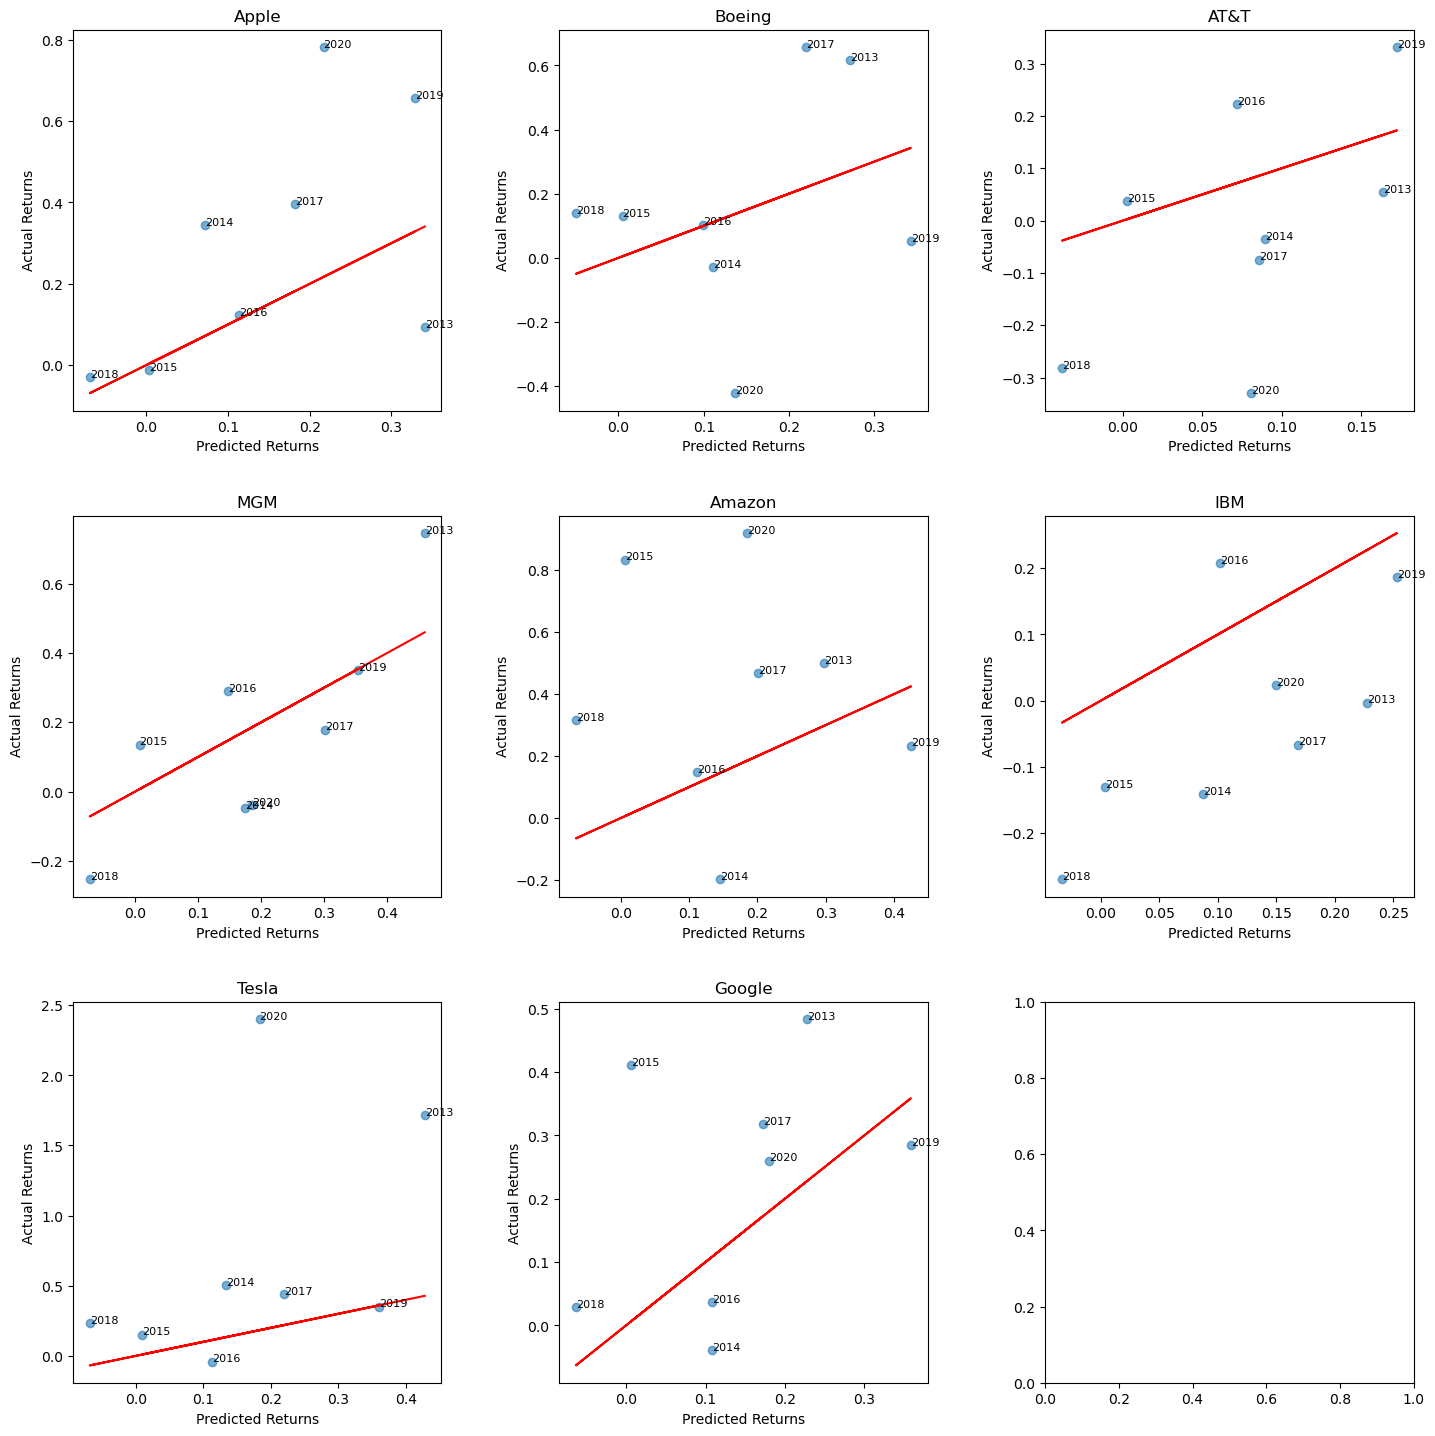

In [32]:
fig, axs = plt.subplots(3,3, figsize=(15, 15)) #create a 3x3 grid of subplots
axs = axs.flatten() #flatten the grid to iterate over it more easily
for i, stock in enumerate(stocks_tickers[:-1]): 
    axs[i].scatter(features[f'{stock} prediction'], features[stock], alpha=0.6) #scatter plot of the stock's returns vs. the S&P500 returns
    for year in features.index:
        axs[i].text(features.loc[year, f'{stock} prediction'], features.loc[year, stock], year, fontsize=8)
    axs[i].set_title(stocks_names[i])
    axs[i].plot(features[f'{stock} prediction'], features[f'{stock} prediction'], color='red')
    axs[i].set_xlabel('Predicted Returns') 
    axs[i].set_ylabel('Actual Returns')
plt.tight_layout(pad=3.0)
plt.show()

The scatterplots in the previous cell demonstrate the extreme difference between the actual returns of each stock for each year, and the returns predicted using the previous year's beta. If the CAPM would have been a good predictor, the plotted dots should have layed on the red line.


In [40]:
#for each portfolio, we compute time-series average of beta and excess return
stocks_betas = [final_df[f'{stock} Beta'].mean() for stock in stocks_tickers[:-1]] #average beta for each stock over the whole period
stocks_returns = [final_df[stock].mean() for stock in stocks_tickers[:-1]] #average returns for each stock over the whole period
portfolios_df = pd.DataFrame({'Stock': stocks_tickers[:-1], 'Beta': stocks_betas, 'Excess Return': stocks_returns})

#we plot the portfolios on a scatter plot
fig = px.scatter(portfolios_df, x='Beta', y='Excess Return', text='Stock', title='Excess Return vs. Beta')
fig.update_traces(textposition='top center')
fig.update_layout(xaxis_title='Beta', yaxis_title='Excess Return')
fig.show()

From the scatterplot, it is once again evident how the actual returns of the stocks (over the whole period) do not coincide with the assets' betas. As an example, it can be noted that despite IBM's beta is higher that AT&T's, the two stocks returns were almost identical. Similarly, it can be noted that despite Tesla's beta is only sitting at around 1.4, its returns were almost double those of many other assets with a beta of 1.1. These incongruencies are even more striking if we also consider MGM's returns being a third of Tesla's, despite an higher beta of 1.5. 

### Interpretation of the results

The analysis carried in task 3 has revealed the limitations of the CAPM as a prediction tool. Not only the betas  (computed a posteriori for the whole period) did not adequately represent the stocks' historical returns, but their usefulness as a prediction tool is null. There may be multiple reasons for these outcomes.

First of all, the CAPM rests on the very strong assumption that each investor acts logically and in the same way. This means that each agent holds the market portfolio and allocate its wealth proportionally across all assets in the same manner. This, however, is far from what happens in the real world. Information asymmetries, for example, play a significant role, as different investors have different level of access and types of information about the market. furthermore, psychological biases and emotional reactions can lead to inefficient and different investment strategies. For example, some investors might react to news on the market with increased conservatism, while others may be more risk-tolerant. 

Secondly, each firm's return is computed by accounting for its systematic risk exlcusively. Despite the idea that idiosyncratic risk can be accounted for through diversification, each firm is subject to both internal and external forces that shift greatly over time. A firm's beta for a specific period may thus change significantly due to unforeseen circumstances or events that change the status quo. Let's say, for example, that a firm is subject to a financial scandal in year X. The firm's beta for year X-1 consequently does not take into account this new event, and therefore its risk profile is not "up to date". Similarly, macroeconomic events such as hikes in interest rate, technological disruptions or sector-specific risks may impact stock returns in ways that cannot be accounted through the beta alone.

## Task 4

In [33]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
wiki_page = requests.get(url).content
soup = BeautifulSoup(wiki_page, 'html.parser')
tics = soup.find_all('td')
wiki_tickers = [tic.find('a', attrs = {'class' : 'external text'}).text for tic in tics if tic.find('a', attrs = {'class' : 'external text'})]
print('number of tickers:', len(wiki_tickers))

number of tickers: 503


In [34]:
date1 = pd.to_datetime('2012-01-12')
date2 = pd.to_datetime('2020-08-12')
data = yf.download(wiki_tickers, start=date1, end=date2)

[*********************100%***********************]  503 of 503 completed

12 Failed downloads:
['GEV', 'KVUE', 'GEHC', 'PLTR', 'SW', 'CEG', 'SOLV', 'AMTM', 'ABNB', 'VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2012-01-12 00:00:00 -> 2020-08-12 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1326344400, endDate = 1597204800")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2012-01-12 00:00:00 -> 2020-08-12 00:00:00)')


In [35]:
data

Price                      Adj Close                                         \
Ticker                             A        AAPL       ABBV ABNB        ABT   
Date                                                                          
2012-01-12 00:00:00+00:00  25.319349   12.709054        NaN  NaN  20.656807   
2012-01-13 00:00:00+00:00  25.024647   12.661399        NaN  NaN  20.757917   
2012-01-17 00:00:00+00:00  25.620461   12.808880        NaN  NaN  20.862772   
2012-01-18 00:00:00+00:00  26.440525   12.941886        NaN  NaN  20.731695   
2012-01-19 00:00:00+00:00  26.812113   12.900865        NaN  NaN  20.757917   
...                              ...         ...        ...  ...        ...   
2020-08-05 00:00:00+00:00  95.215614  107.364426  78.975235  NaN  95.218254   
2020-08-06 00:00:00+00:00  94.787643  111.110291  78.399330  NaN  94.854691   
2020-08-07 00:00:00+00:00  95.108650  108.584114  78.695740  NaN  94.369926   
2020-08-10 00:00:00+00:00  94.486107  110.162376  78.238411  NaN  93.260582   
2020-08-11 00:00:00+00:00  93.669067  106.886169  78.484024  NaN  92.346985   

Price                                                                     \
Ticker                          ACGL         ACN        ADBE         ADI   
Date                                                                       
2012-01-12 00:00:00+00:00  12.403333   42.740311   29.230000   27.830175   
2012-01-13 00:00:00+00:00  12.390000   42.193584   28.969999   27.315495   
2012-01-17 00:00:00+00:00  12.313333   42.383751   29.350000   27.628788   
2012-01-18 00:00:00+00:00  12.320000   43.540600   29.889999   29.202665   
2012-01-19 00:00:00+00:00  12.296667   43.421753   30.240000   29.590542   
...                              ...         ...         ...         ...   
2020-08-05 00:00:00+00:00  30.820000  215.944107  449.510010  107.633171   
2020-08-06 00:00:00+00:00  31.320000  218.011917  464.109985  108.161308   
2020-08-07 00:00:00+00:00  32.490002  218.644592  449.570007  107.772171   
2020-08-10 00:00:00+00:00  32.730000  217.492630  443.290009  108.179825   
2020-08-11 00:00:00+00:00  32.849998  215.821381  435.230011  107.994530   

Price                                 ...   Volume                     \
Ticker                           ADM  ...      WTW       WY      WYNN   
Date                                  ...                               
2012-01-12 00:00:00+00:00  20.694538  ...   179388  6415300   6974000   
2012-01-13 00:00:00+00:00  20.715841  ...   269761  6891700   2641400   
2012-01-17 00:00:00+00:00  20.438869  ...   237296  8744000   3459400   
2012-01-18 00:00:00+00:00  20.751350  ...   206228  4887000   2978200   
2012-01-19 00:00:00+00:00  20.893389  ...   236655  6765100   2153600   
...                              ...  ...      ...      ...       ...   
2020-08-05 00:00:00+00:00  38.941730  ...   999400  4134300   7054700   
2020-08-06 00:00:00+00:00  39.130409  ...  1010400  3524400   7673800   
2020-08-07 00:00:00+00:00  39.561699  ...   682100  3187100   4874800   
2020-08-10 00:00:00+00:00  39.975021  ...   427900  6062500   9703800   
2020-08-11 00:00:00+00:00  39.885166  ...  1232100  4798900  11414400   

Price                                                                    \
Ticker                         XEL       XOM      XYL      YUM      ZBH   
Date                                                                      
2012-01-12 00:00:00+00:00  3898800  17357200   709300  4792691  1604122   
2012-01-13 00:00:00+00:00  3162300  15551600   886200  5074646  1077689   
2012-01-17 00:00:00+00:00  3646100  15627900   465400  4190805  1495869   
2012-01-18 00:00:00+00:00  2197000  16754200  1453700  5246852  1347961   
2012-01-19 00:00:00+00:00  2522800  16383500   838000  5009687  1873467   
...                            ...       ...      ...      ...      ...   
2020-08-05 00:00:00+00:00  2624000  17175100   953800  1243200  1204276   
2020-08-06 00:00:00+00:00  2398800  14434900   731000  

The dataframe displayed above includes data for all the 503 stocks that influence the S&P500 index. During the scraping process, we selected the same starting and ending date as the ones of the PC Lab data provided in class, in order to have the same number of rows.

Looking at the data, we can see how the number of variables is way higher compared to the PC Lab data. The `yfinance` package allowed us to retrieve stock data for the following categories:
- Adj Close: It adjusts the closing price taking into account all corporate actions (such as stock splits or dividends) in order to provide a more accurate historical price.
- Close: The last price at which the stock traded when the market closed for the day.
- High: The highest price at which the stock traded during the trading session.
- Low: The lowest price at which the stock traded during the trading session.
- Open: The first price at which the stock was traded when the market opened on a specific day.
- Volume: The total number of shares traded during the trading session.